# Characters

NEW REPLACEMENT

This data frame lists all characters, their movie, their gender, and their credit position. The `character_ID` column is later referenced in other data frames.

In [3]:
# import packages
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [4]:
# turn off pretty printing
%pprint

Pretty printing has been turned ON


## Loading in the data and basic summary

In [5]:
# creating the df
characters_df = pd.read_csv('./data/movie_characters_metadata.txt', sep='\s+\+\+\+\$\+\+\+\s?',
                            names = ['character_ID', 'character_name', 'movie_ID', 'movie_title', 'gender', 'credit_position'], 
                            index_col='character_ID', dtype='string', engine='python', encoding='ISO-8859-1')

The data was all separated with ' +++$+++ ' and did not have column names. The README described what each column was in the data so I used that to create column names. Where logical, I made the index of the df the initial ID column.

In [6]:
characters_df.shape

(9035, 5)

In [7]:
characters_df.info()
# some characters are unnamed

<class 'pandas.core.frame.DataFrame'>
Index: 9035 entries, u0 to u9034
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   character_name   9033 non-null   string
 1   movie_ID         9035 non-null   string
 2   movie_title      9035 non-null   string
 3   gender           9035 non-null   string
 4   credit_position  9035 non-null   string
dtypes: string(5)
memory usage: 423.5+ KB


In [8]:
characters_df.head()

,character_name,movie_ID,movie_title,gender,credit_position
character_ID,,,,,
u0,BIANCA,m0,10 things i hate about you,f,4
u1,BRUCE,m0,10 things i hate about you,?,?
u2,CAMERON,m0,10 things i hate about you,m,3
u3,CHASTITY,m0,10 things i hate about you,?,?
u4,JOEY,m0,10 things i hate about you,m,6


Some gender makers are missing for characters in this dataframe, I will work on filling in the missing data.

In [9]:
# how many characters are missing gender?
characters_df.groupby('gender').count()

,character_name,movie_ID,movie_title,credit_position
gender,,,,
?,6018,6020,6020,6020
F,45,45,45,45
M,150,150,150,150
f,921,921,921,921
m,1899,1899,1899,1899


Looks like a lot of missing gender markers! Looks like some of the flags are inconsist too, there is 'm' and 'M.'

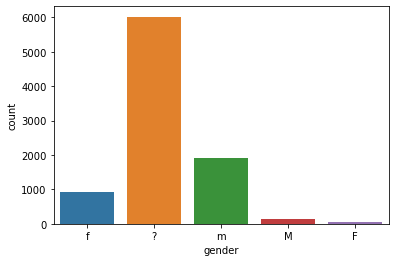

In [10]:
sns.countplot(x = "gender",
             data = characters_df)
plt.show()

In [11]:
# making all gender markers uppercase
characters_df['gender'] = characters_df.gender.map(lambda x: re.sub(r'f', r'F', x))
characters_df['gender'] = characters_df.gender.map(lambda x: re.sub(r'm', r'M', x))

In [12]:
characters_df.describe()

,character_name,movie_ID,movie_title,gender,credit_position
count,9033,9035,9035,9035,9035
unique,5355,617,617,3,57
top,MAN,m289,casino,?,?
freq,44,44,44,6020,6356


## Generating Gender Markers

In [13]:
# df for characters without gender markers
characters_ng_df = characters_df[characters_df.gender == '?']

In [14]:
# drop gender, it will get added back below
characters_ng_df=characters_ng_df[['character_name', 'movie_ID', 'movie_title', 'credit_position']]

In [15]:
characters_ng_df

,character_name,movie_ID,movie_title,credit_position
character_ID,,,,
u1,BRUCE,m0,10 things i hate about you,?
u3,CHASTITY,m0,10 things i hate about you,?
u8,MISS PERKY,m0,10 things i hate about you,?
u10,SHARON,m0,10 things i hate about you,?
u12,ALONSO,m1,1492: conquest of paradise,?
...,...,...,...,...
u9030,DURNFORD,m616,zulu dawn,?
u9031,MELVILL,m616,zulu dawn,?
u9032,NORRIS-NEWMAN,m616,zulu dawn,?


In [16]:
# I will use the names corpus from NLTK to fill in some gaps in gender data
names = nltk.corpus.names
male_names = names.words('male.txt')
female_names = names.words('female.txt')

In [17]:
# make each list a df
female_df = pd.DataFrame()
female_df['name'] = female_names
female_df['gender'] = 'F'
male_df = pd.DataFrame()
male_df['name'] = male_names
male_df['gender'] = 'M'

In [18]:
female_df.head()

,name,gender
0,Abagael,F
1,Abagail,F
2,Abbe,F
3,Abbey,F
4,Abbi,F


In [19]:
male_df.head()

,name,gender
0,Aamir,M
1,Aaron,M
2,Abbey,M
3,Abbie,M
4,Abbot,M


Some names are on both lists, I will have to flag them as ambiguous.

In [20]:
names_df = pd.concat([female_df, male_df])

In [21]:
names_df

,name,gender
0,Abagael,F
1,Abagail,F
2,Abbe,F
3,Abbey,F
4,Abbi,F
...,...,...
2938,Zeus,M
2939,Zippy,M
2940,Zollie,M
2941,Zolly,M


In [22]:
names_df.name.value_counts().value_counts()
# 365 names could be male or female

1    7214
2     365
Name: name, dtype: int64

In [23]:
# create new df with only duplicated names
names_df_dup = names_df[names_df['name'].duplicated(keep=False)]

# replace the gender with "A"
names_df_dup['gender'] = names_df_dup.gender.map(lambda x: re.sub(r'[F M]', r'A', x))

# remove duplicates
names_df_dup.drop_duplicates(subset='name',keep='first', inplace=True)

<ipython-input-23-03ffade00a27>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  names_df_dup['gender'] = names_df_dup.gender.map(lambda x: re.sub(r'[F M]', r'A', x))
<ipython-input-23-03ffade00a27>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  names_df_dup.drop_duplicates(subset='name',keep='first', inplace=True)


In [24]:
names_df_dup

,name,gender
3,Abbey,A
5,Abbie,A
6,Abby,A
16,Addie,A
40,Adrian,A
...,...,...
4919,Willie,A
4921,Willy,A
4935,Winnie,A
4937,Winny,A


In [25]:
# drop all ambiguous names from original df
names_df.drop_duplicates(subset='name',keep=False, inplace=True)

# add ambiguous marked back to original df
names_df=pd.concat([names_df, names_df_dup])

# change names to uppercase to match characters_df
names_df['name'] = names_df.name.map(lambda x: x.upper())

In [26]:
names_df

,name,gender
0,ABAGAEL,F
1,ABAGAIL,F
2,ABBE,F
4,ABBI,F
7,ABIGAEL,F
...,...,...
4919,WILLIE,A
4921,WILLY,A
4935,WINNIE,A
4937,WINNY,A


In [27]:
characters_ng_df = pd.merge(characters_ng_df, names_df, left_on='character_name', right_on='name', how='left')

In [28]:
# this loses the original index, which i need
characters_ng_df

,character_name,movie_ID,movie_title,credit_position,name,gender
0,BRUCE,m0,10 things i hate about you,?,BRUCE,M
1,CHASTITY,m0,10 things i hate about you,?,CHASTITY,F
2,MISS PERKY,m0,10 things i hate about you,?,NaN,NaN
3,SHARON,m0,10 things i hate about you,?,SHARON,F
4,ALONSO,m1,1492: conquest of paradise,?,ALONSO,M
...,...,...,...,...,...,...
6015,DURNFORD,m616,zulu dawn,?,NaN,NaN
6016,MELVILL,m616,zulu dawn,?,NaN,NaN
6017,NORRIS-NEWMAN,m616,zulu dawn,?,NaN,NaN
6018,STUART SMITH,m616,zulu dawn,?,NaN,NaN


In [29]:
characters_ng_df.groupby('gender').count()

,character_name,movie_ID,movie_title,credit_position,name
gender,,,,,
A,405,405,405,405,405
F,676,676,676,676,676
M,1148,1148,1148,1148,1148


Initially 6020 characters were missing gender markers, using NLTK name list added 2229 gender markers. That is a third of all missing markers, pretty good I think!

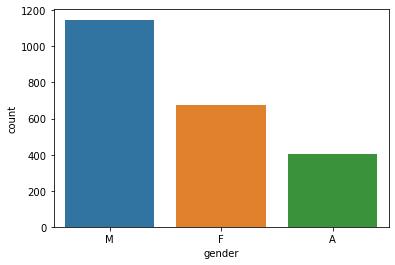

In [30]:
sns.countplot(x = "gender",
             data = characters_ng_df)
plt.show()

In [31]:
characters_ng_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6020 entries, 0 to 6019
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   character_name   6018 non-null   object
 1   movie_ID         6020 non-null   string
 2   movie_title      6020 non-null   string
 3   credit_position  6020 non-null   string
 4   name             2229 non-null   object
 5   gender           2229 non-null   object
dtypes: object(3), string(3)
memory usage: 329.2+ KB


In [32]:
# there are two characters missing names
characters_ng_df[characters_ng_df.character_name.isnull()]

,character_name,movie_ID,movie_title,credit_position,name,gender
2492,<NA>,m248,arctic blue,?,NaN,NaN
4371,<NA>,m436,memento,?,NaN,NaN


In [33]:
# i will replace them with empty strings for now
characters_ng_df['character_name'].fillna('', inplace=True)

Miss Perky is a character, are there other character names that have honorifics or anything else that can help generate gender?

In [34]:
characters_ng_df[characters_ng_df.character_name.str.contains('MISS ')]

,character_name,movie_ID,movie_title,credit_position,name,gender
2,MISS PERKY,m0,10 things i hate about you,?,NaN,NaN
199,MISS GALLAGHER,m17,an american werewolf in london,?,NaN,NaN
385,MISS SWEET,m35,blast from the past,?,NaN,NaN
1310,MISS DUNNE,m128,malcolm x,?,NaN,NaN
1521,MISS HO KYM,m145,next friday,?,NaN,NaN
1658,MISS WILSON,m161,platinum blonde,?,NaN,NaN
1774,MISS GOTTSCHALK,m174,the seventh victim,?,NaN,NaN
1775,MISS SUMMERS,m174,the seventh victim,?,NaN,NaN
2326,MISS SLOVIAK,m230,wonder boys,?,NaN,NaN
2395,MISS CASWELL,m238,all about eve,?,NaN,NaN


In [35]:
characters_ng_df[characters_ng_df.character_name.str.contains('MISTER ')]

,character_name,movie_ID,movie_title,credit_position,name,gender
3147,MISTER BLACK,m315,dark city,?,NaN,NaN
3249,MISTER SEÑOR LOVE DADDY,m326,do the right thing,?,NaN,NaN


In [132]:
characters_ng_df[characters_ng_df.character_name.str.contains('MR. ')]

,character_name,movie_ID,movie_title,credit_position,name,gender
283,MR. T,m24,bachelor party,?,NaN,NaN
284,MR. THOMERSON,m24,bachelor party,?,NaN,NaN
397,MR. BEAUMONT,m36,blue velvet,?,NaN,NaN
448,MR. MILLER,m41,the butterfly effect,?,NaN,NaN
486,MR. LEWIS,m45,confidence,?,NaN,NaN
...,...,...,...,...,...,...
5784,MR. ARKADY,m589,u turn,?,NaN,NaN
5840,MR. FISHER,m595,very bad things,?,NaN,NaN
5872,MR. YOUNG,m598,wag the dog,?,NaN,NaN
5900,MRS WEBSTER,m600,waxwork,?,NaN,NaN


In [133]:
characters_ng_df[characters_ng_df.character_name.str.contains('MRS. ')]

,character_name,movie_ID,movie_title,credit_position,name,gender
90,MRS. JORDAN,m8,a nightmare on elm street: the dream child,?,NaN,NaN
101,MRS. GORDON,m10,affliction,?,NaN,NaN
149,MRS. HAMMEN,m13,airplane!,?,NaN,NaN
150,MRS. KRAMER,m13,airplane!,?,NaN,NaN
200,MRS. HOBBS,m17,an american werewolf in london,?,NaN,NaN
...,...,...,...,...,...,...
5483,MRS. MOEBIUS,m560,the believer,?,NaN,NaN
5499,MRS. CARVER,m562,the hebrew hammer,?,NaN,NaN
5678,MRS. BAKER,m578,to sleep with anger,?,NaN,NaN
5906,MRS. FRANK,m601,what lies beneath,?,NaN,NaN


In [134]:
characters_ng_df[characters_ng_df.character_name.str.contains('MS. ')]

,character_name,movie_ID,movie_title,credit_position,name,gender
528,MS. FARMER,m50,donnie darko,?,NaN,NaN
529,MS. POMEROY,m50,donnie darko,?,NaN,NaN
1528,MS. JONES,m146,nick of time,?,NaN,NaN
2229,MS. GORDON,m223,true believer,?,NaN,NaN
2604,MS. B. HAVEN,m260,batman and robin,?,NaN,NaN
3310,MS. HOY,m331,election,?,NaN,NaN


In [151]:
characters_ng_df[characters_ng_df.character_name.str.contains('DR. ')]
# i will tag these as ambiguous

,character_name,movie_ID,movie_title,credit_position,name,gender
141,DR. RUMACK,m13,airplane!,?,NaN,NaN
269,DR. DARLING,m23,the avengers,?,NaN,NaN
345,DR. BENNETT,m30,big fish,?,NaN,NaN
522,DR. MONNITOFF,m50,donnie darko,?,NaN,NaN
1146,DR. RAY,m115,labor of love,?,NaN,NaN
1147,DR. ROYCE,m115,labor of love,?,NaN,NaN
1246,DR. ROGOFF,m123,lost highway,?,NaN,NaN
1274,DR. EDDIE,m126,minority report,?,NaN,NaN
1302,DR. PAYSON,m128,malcolm x,?,NaN,NaN
1333,DR. KEEGAN,m130,marty,?,NaN,NaN


In [136]:
characters_ng_df[characters_ng_df.character_name.str.contains('SIR ')]

,character_name,movie_ID,movie_title,credit_position,name,gender
94,SIR IAN,m9,the atomic submarine,?,NaN,NaN
273,SIR AUGUST,m23,the avengers,?,NaN,NaN
335,SIR WILLIAM,m28,barry lyndon,?,NaN,NaN
1897,SIR IVY,m186,smokin' aces,?,NaN,NaN
3112,SIR TE,m310,"crouching tiger, hidden dragon",?,NaN,NaN
3417,SIR ECTOR,m340,excalibur,?,NaN,NaN
5050,SIR ROBERT,m511,shakespeare in love,?,NaN,NaN
5902,SIR WILFRED,m600,waxwork,?,NaN,NaN


In [43]:
characters_ng_df[characters_ng_df.character_name.str.contains('MAN ')]

,character_name,movie_ID,movie_title,credit_position,name,gender
514,MAN WITH COAT,m49,detroit rock city,?,NaN,NaN
887,TAVERN MAN #2,m89,highlander,?,NaN,NaN
1577,MAN AT CHAIR,m151,no country for old men,?,NaN,NaN
1927,GERMAN LIEUTENANT,m190,stalag 17,?,NaN,NaN
2021,REMAN OFFICER,m198,star trek: nemesis,?,NaN,NaN
2085,MAN IN BUSINESS SUIT,m205,taxi driver,?,NaN,NaN
2248,MAN FROM ANOTHER PLACE,m224,twin peaks: fire walk with me,?,NaN,NaN
2282,HIGHWAY PATROLMAN #1,m227,new nightmare,?,NaN,NaN
2453,MAN IN LINE,m243,annie hall,?,NaN,NaN
2669,HARRY S. TRUMAN PUPPET,m267,being john malkovich,?,NaN,NaN


In [39]:
characters_ng_df[characters_ng_df.character_name.str.contains('WOMAN')]

,character_name,movie_ID,movie_title,credit_position,name,gender
2675,WOMAN #1,m267,being john malkovich,?,NaN,NaN
2806,WOMAN CLERK,m282,the bourne identity,?,NaN,NaN
5774,WOMAN CABBIE,m587,twelve monkeys,?,NaN,NaN


In [143]:
characters_ng_df[characters_ng_df.character_name.str.contains('BOY')]

,character_name,movie_ID,movie_title,credit_position,name,gender
378,BELLBOY,m35,blast from the past,?,NaN,NaN
556,BOY,m53,the elephant man,?,NaN,NaN
1003,BOY,m103,it happened one night,?,NaN,NaN
1434,BOY,m139,mr. smith goes to washington,?,NaN,NaN
1489,INVISIBLE BOY,m143,mystery men,?,NaN,NaN
1663,BOY,m162,pleasantville,?,NaN,NaN
1788,BOY,m176,shivers,?,NaN,NaN
1984,THE BOY,m194,star trek iv: the voyage home,?,NaN,NaN
2369,BOYS,m235,a hard day's night,?,NaN,NaN
2542,BOY,m254,badlands,?,NaN,NaN


In [144]:
characters_ng_df[characters_ng_df.character_name.str.contains('GIRL')]

,character_name,movie_ID,movie_title,credit_position,name,gender
57,GIRL,m5,the fifth element,?,NaN,NaN
142,GIRL,m13,airplane!,?,NaN,NaN
488,SALESGIRL,m45,confidence,?,NaN,NaN
540,FRY GIRL #1,m51,drop dead gorgeous,?,NaN,NaN
550,PREGNANT FRY GIRL,m51,drop dead gorgeous,?,NaN,NaN
566,GIRL,m54,erik the viking,?,NaN,NaN
600,GIRL,m59,fast times at ridgemont high,?,NaN,NaN
725,GIRL,m72,ghost world,?,NaN,NaN
819,GIRL AT THE WINDOW,m83,hardcore,?,NaN,NaN
1093,GIRL LAB PARTNER,m109,juno,?,NaN,NaN
